# Transfer Learning

Nesse exemplo vamos usar um toy dataset para comparar um modelo pré treinado com um sem pré treino

## Imports

Vamos usar a biblioteca tensorflow/Keras o treinamento

In [1]:
import numpy as np

import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import time
import os

## Uso do google colab

Para facilitar nossas computações, vamos usar a placa A100 do google colab pro

Essa célula vai nos permitir carregar o Google Drive dentro do colab para carregar nosso dataset

In [2]:
# Pra rodar no colab caso seja util (Tem que ter os dados de treino no drive)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Essa célula pega nosso arquivo zipado do google drive e carrega no ambiente local

In [4]:
# Defina o caminho para o seu arquivo .zip no Google Drive
zip_path_in_drive = '/content/drive/MyDrive/treino.zip'  # <-- MUDE AQUI para o caminho e nome corretos

# Copia o arquivo para o disco local do Colab
!cp '{zip_path_in_drive}' /content/

print(f"Arquivo '{zip_path_in_drive.split('/')[-1]}' copiado com sucesso para o ambiente do Colab.")

Arquivo 'treino.zip' copiado com sucesso para o ambiente do Colab.


Essa célula pega nosso cojunto de dados do zip e carrega para o ambiente local

In [5]:
# Nome do arquivo zip que foi copiado
zip_name = 'treino.zip'  # <-- MUDE AQUI se o nome do seu arquivo for diferente

# Descompacta o arquivo no diretório /content/dataset_local/
# O comando -q (quiet) evita mostrar a lista de todos os arquivos descompactados
!unzip -q /content/{zip_name} -d /content/dataset_local/

print("Dataset descompactado com sucesso no diretório local '/content/dataset_local/'.")

Dataset descompactado com sucesso no diretório local '/content/dataset_local/'.


In [6]:
# Para checar se a GPU do colab está ativa
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Carregando a base

Vamos usar a função do keras: keras.utils.image_dataset_from_directory em que cada todas as imagens devem estar sapearadas por pastas, ou seja, imagens da classe 1 devem estar em um pasta diferente das imagens da classe 2 e assim por diante. Todas as pastas de classes devem estar na mesma pasta que vai ser carregada

In [7]:
train_ds = keras.utils.image_dataset_from_directory(
    r'/content/dataset_local/content/drive/MyDrive/treino', # A localização da pasta
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    subset="training",
    seed = 123)

validation_ds = keras.utils.image_dataset_from_directory(
    r'/content/dataset_local/content/drive/MyDrive/treino', # A localização da pasta
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    shuffle=True,
    validation_split=0.1,
    subset="validation",
    seed = 123)

# Passar 60 baches de treino para teste
test_ds = train_ds.take(60)
train_ds = train_ds.skip(60)


Found 6499 files belonging to 75 classes.
Using 5850 files for training.
Found 6499 files belonging to 75 classes.
Using 649 files for validation.


In [8]:
# Essa é a quantidade de batchs e cada batch tem 32 imagens
print(f"Number of training samples: {train_ds.cardinality()}")
print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f'Number of testing samples: {test_ds.cardinality()}')

Number of training samples: 123
Number of validation samples: 21
Number of testing samples: 60


Aqui vamos editar as fotos para terem tamanho 150x150 para o modelo Xception e vamos artificialmente aumentar o conjunto de treino

In [9]:
resize_fn = keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))


# Como queremos criar um conjunto de dados aumentado então vamos multiplicar o número de imagens por 5
train_ds = train_ds.repeat(5)

In [ ]:
augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x


augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y)).cache() # O .cache() faz com que o dataset fique na memoria RAM para acelerar o treino e faz com que ele não seja recalculado a cada época

In [11]:
# Em bachts de 32

print(f"Number of training samples: {train_ds.cardinality()}")

# Agora a gente tem 615 batches (5 vezes mais que antes), quando usamos o flat_map o keras para de ficar sabendo quantos batches tem diretamente pelo .cardinality()

print(f"Number of validation samples: {validation_ds.cardinality()}")
print(f'Number of testing samples: {test_ds.cardinality()}')

print(f"Number of augmented training samples: {augmented_train_ds.cardinality()}")

Number of training samples: 615
Number of validation samples: 21
Number of testing samples: 60
Number of augmented training samples: 615


Uma amostra de uma imagem e suas possíveis variações que criamos artificialmente

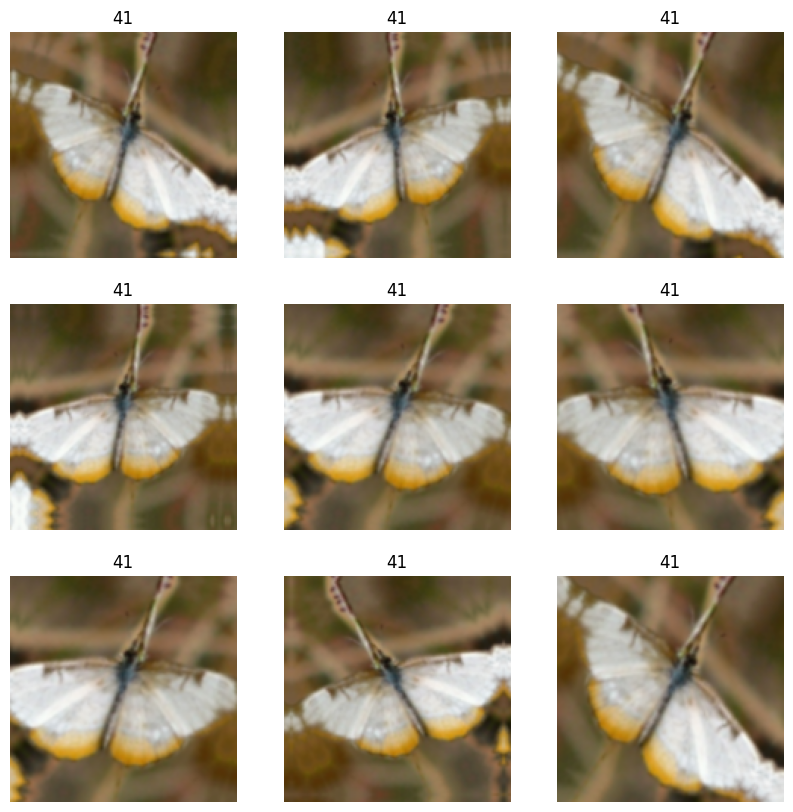

In [12]:
for images, labels in augmented_train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(np.expand_dims(first_image, 0))
        plt.imshow(np.array(augmented_image[0]).astype("int32"))
        plt.title(int(labels[0]))
        plt.axis("off")

# Criação dos modelos

Vamos criar modelos do Xception com e sem pré treino, também vamos usar um com pré treino e com data augmentation e um modelo toy para comparação

In [13]:
base_model_com_pretreino_augmented = keras.applications.Xception(
    weights="imagenet",  # Carregando os pesos do modelo pré-treinado no dataset imaginet.
    input_shape=(150, 150, 3),
    include_top=False,  # Tirar o classificador final do modelo
) # O imaginet 1000 utilizado contém 5 espécies de borboletas (ringlet, monarch, cabbage, sulphur, lycaenid) e só monarch e cabbage aparecem no nosso dataset.

# Congelando o modelo base
base_model_com_pretreino_augmented.trainable = False

# O input do modelo
inputs = keras.Input(shape=(150, 150, 3))

# O Xception pré treinado requer que os insputs tenham essa escala.
# de (0, 255) para (-1., +1.).
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# ==== Augmented ===== (Mesmas de antes)

x = keras.layers.RandomFlip("horizontal")(x)
x = keras.layers.RandomRotation(0.1)(x)
x = keras.layers.RandomZoom(0.1)(x)

# ====================

x = base_model_com_pretreino_augmented(x, training=False) # Passar o training = False para deixar o batchnorming layer do base_model em modo inferência.


x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizar com dropout

outputs = keras.layers.Dense(75, activation="softmax")(x) # saída com 75 classes pois temos 75 espécies de borboletas no dataset.

# Criar o modelo final
model_com_pretreino_augmented = keras.Model(inputs, outputs)

model_com_pretreino_augmented.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


model_com_pretreino_augmented.summary(show_trainable=True)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling (Rescaling)       │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ random_flip_1 (RandomFlip)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ random_rotation_1           │ (None, 150, 150, 3)   │          0 │   -   │
│ (RandomRotation)            │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ random_zoom_1 (RandomZoom)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 75)            │    153,675 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 21,015,155 (80.17 MB)

 Trainable params: 153,675 (600.29 KB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [14]:
# Load the pretrained Xception base (no top) and freeze it
base_model_com_pretreino = keras.applications.Xception(
    weights="imagenet",   # Carregando os pesos do modelo pré-treinado no dataset imaginet.
    input_shape=(150, 150, 3),
    include_top=False,
)
base_model_com_pretreino.trainable = False


global_pool = keras.layers.GlobalAveragePooling2D()
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)

input_layer = keras.Input(shape=(150, 150, 3))
x = scale_layer(input_layer)
feature_maps = base_model_com_pretreino(x, training=False)
features = global_pool(feature_maps)

feature_extractor_model = keras.Model(input_layer, features)

train_features = feature_extractor_model.predict(train_ds)
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

validation_features = feature_extractor_model.predict(validation_ds)
validation_labels = np.concatenate([y for x, y in validation_ds], axis=0)

test_features = feature_extractor_model.predict(test_ds)
test_labels = np.concatenate([y for x, y in test_ds], axis=0)


feature_input = keras.Input(shape=(2048,))

x = keras.layers.Dropout(0.2)(feature_input)
output = keras.layers.Dense(75, activation='softmax')(x)

model_com_pretreino = keras.Model(feature_input, output)


model_com_pretreino.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_com_pretreino.summary(show_trainable=True)

615/615 ━━━━━━━━━━━━━━━━━━━━ 52s 48ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 15s 726ms/step
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_4 (InputLayer)  │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 75)            │    153,675 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 153,675 (600.29 KB)

 Trainable params: 153,675 (600.29 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
base_model_sem_pretreino = keras.applications.Xception(
    weights=None,  # Não carregar os pesos do modelo pré-treinado no dataset imaginet.
    input_shape=(150, 150, 3),
    include_top=False,  # Tirar o classificador final do modelo
) # O imaginet 1000 utilizado contém 5 espécies de borboletas (ringlet, monarch, cabbage, sulphur, lycaenid) e só monarch e cabbage aparecem no nosso dataset.

# Não precisa congelar o modelo dessa vez

# O input do modelo
inputs = keras.Input(shape=(150, 150, 3))

# O Xception requer que os insputs tenham essa escala.
# de (0, 255) para (-1., +1.).
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

x = base_model_sem_pretreino(x, training=False) # Passar o training = False para deixar o batchnorming layer do base_model em modo inferência.


x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularizar com dropout

outputs = keras.layers.Dense(75, activation="softmax")(x) # saída com 75 classes pois temos 75 espécies de borboletas no dataset.

# Criar o modelo final
model_sem_pretreino = keras.Model(inputs, outputs)

model_sem_pretreino.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)


model_sem_pretreino.summary(show_trainable=True)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_6 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ rescaling_2 (Rescaling)     │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 5, 5, 2048)    │ 20,861,480 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 2048)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 75)            │    153,675 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 21,015,155 (80.17 MB)

 Trainable params: 20,960,627 (79.96 MB)

 Non-trainable params: 54,528 (213.00 KB)

In [16]:
inputs = keras.Input(shape=(150, 150, 3))

# Parte Convolucional

# Conv 1
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x) # Pega janelas 2x2 e tira o maximo (reduz a imagem pela metade)

# Conv 2
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Conv 3
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Conv 4
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same")(x)
x = layers.MaxPooling2D(pool_size=2)(x)

# Conv 5
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same")(x)

# Achatamos a saída do bloco convolucional para um vetor 1D
x = layers.Flatten()(x)

# --- Parte Densa

# Dense 1
x = layers.Dense(512, activation="relu")(x)
x = layers.Dropout(0.5)(x) # Dropout para regularização

# Dense 2
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x) # Dropout para regularização

# Dense 3 (Camada de Saída)
outputs = layers.Dense(75, activation="softmax")(x)

# --- Criação e Compilação do Modelo ---
model_mini = keras.Model(inputs=inputs, outputs=outputs)

model_mini.compile(
    optimizer=keras.optimizers.Adam(),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

model_mini.summary(show_trainable=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_7 (InputLayer)  │ (None, 150, 150, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_12 (Conv2D)          │ (None, 150, 150, 32)  │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d               │ (None, 75, 75, 32)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_13 (Conv2D)          │ (None, 75, 75, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_1             │ (None, 37, 37, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_14 (Conv2D)          │ (None, 37, 37, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_2             │ (None, 18, 18, 128)   │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_15 (Conv2D)          │ (None, 18, 18, 128)   │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_3             │ (None, 9, 9, 128)     │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_16 (Conv2D)          │ (None, 9, 9, 256)     │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 20736)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 512)           │ 10,617,344 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_3 (Dropout)         │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 256)           │    131,328 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_4 (Dropout)         │ (None, 256)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 75)            │     19,275 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 11,303,947 (43.12 MB)

 Trainable params: 11,303,947 (43.12 MB)

 Non-trainable params: 0 (0.00 B)

Essa Callback é para recuperarmos o tempo de treino de cada época

In [17]:
from keras.callbacks import EarlyStopping

# Callback para pegar os tempos

class TimingCallback(tf.keras.callbacks.Callback):
    """Callback para registrar o tempo gasto em cada época."""

    def __init__(self, logs={}):
        self.times = [] # Lista para armazenar os tempos de cada época

    def on_epoch_begin(self, epoch, logs={}):
        """É chamado no início de uma época."""
        self.starttime = time.time() # Registra o tempo de início

    def on_epoch_end(self, epoch, logs={}):
        """É chamado no final de uma época."""
        # Calcula a duração e adiciona à lista
        duration = time.time() - self.starttime
        self.times.append(duration)


time_callback_com_pretreino = TimingCallback()
time_callback_sem_pretreino = TimingCallback()
time_callback_mini_modelo = TimingCallback()
time_callback_com_pretreino_augmented = TimingCallback()

# Treinamento 

Vamos treinar cada modelo com 100 épocas, sendo que caso não tenhamos uma melhora em 20 épocas da loss (sparse_categorical_crossentropy) de validação, vamos interromper o treinamento.


In [18]:
epochs = 100
print("Fitando o modelo com pretreino")
history_com_pretreino = model_com_pretreino.fit(train_features, train_labels, epochs=epochs, validation_data=(validation_features, validation_labels), callbacks=[time_callback_com_pretreino, keras.callbacks.EarlyStopping(verbose=1, monitor='val_loss', patience=20, restore_best_weights=True, min_delta=10e-6)])
print("Fitando o modelo sem pretreino")
history_sem_pretreino = model_sem_pretreino.fit(augmented_train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[time_callback_sem_pretreino, keras.callbacks.EarlyStopping(verbose=1, monitor='val_loss', patience=20, restore_best_weights=True, min_delta=10e-6)])
print("Fitando o mini modelo")
history_mini_modelo = model_mini.fit(augmented_train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[time_callback_mini_modelo, keras.callbacks.EarlyStopping(verbose=1, monitor='val_loss', patience=20, restore_best_weights=True, min_delta=10e-6)])
print("Fitando o modelo com pretreino e data augmentation")
# A diferença para esse é que as camadas de augmented estão dentro do modelo, então em cada epoch vai ser uma combinação um pouco diferente e isso deve melhorar o modelo
history_com_pretreino_augmented = model_com_pretreino_augmented.fit(train_ds, epochs=epochs, validation_data=validation_ds, callbacks=[time_callback_com_pretreino_augmented, keras.callbacks.EarlyStopping(verbose=1, monitor='val_loss', patience=20, restore_best_weights=True, min_delta=10e-6)])

Fitando o modelo com pretreino
Epoch 1/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.0148 - loss: 4.7977 - val_accuracy: 0.0185 - val_loss: 4.6326
Epoch 2/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0311 - loss: 4.4062 - val_accuracy: 0.0108 - val_loss: 4.7645
Epoch 3/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0440 - loss: 4.2399 - val_accuracy: 0.0123 - val_loss: 4.7958
Epoch 4/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0518 - loss: 4.1270 - val_accuracy: 0.0123 - val_loss: 4.8234
Epoch 5/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0655 - loss: 4.0312 - val_accuracy: 0.0077 - val_loss: 4.8694
Epoch 6/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0682 - loss: 3.9887 - val_accuracy: 0.0185 - val_loss: 4.8716
Epoch 7/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0755 - loss: 3.9269 - val_accuracy: 0.0154 - val_loss: 4.9019
Epoch 8/100
615/615 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0

# Plots

Vamos plotar gráficos da acurácia, loss e tempo por época para facilitar a visualização.

Podemos ver que o modelo com pré treino vai muito mal, isso porque ele acaba overfitando muito rápido já que as imagens são grandes se comparadas com a quantidade de parâmetros treináveis. Já o modelo com pré treino + data augmentation vai muito bem pois apesar de ter poucos parâmetros para treinar ele tem acesso a muito mais exemplos.


In [19]:
# Extrair os dados do objeto history
acc_com_pretreino = history_com_pretreino.history['accuracy']
val_acc_com_pretreino = history_com_pretreino.history['val_accuracy']
loss_com_pretreino = history_com_pretreino.history['loss']
val_loss_com_pretreino = history_com_pretreino.history['val_loss']
epoch_times_com_pretreino = time_callback_com_pretreino.times
epochs_range_com_pretreino = range(1, len(acc_com_pretreino) + 1) # Só para não começar do 0

In [20]:
# Extrair os dados do objeto history
acc_sem_pretreino = history_sem_pretreino.history['accuracy']
val_acc_sem_pretreino = history_sem_pretreino.history['val_accuracy']
loss_sem_pretreino = history_sem_pretreino.history['loss']
val_loss_sem_pretreino = history_sem_pretreino.history['val_loss']
epoch_times_sem_pretreino = time_callback_sem_pretreino.times
epochs_range_sem_pretreino = range(1, len(acc_sem_pretreino) + 1) # Só para não começar do 0

In [21]:
# Extrair os dados do objeto history
acc_mini_modelo = history_mini_modelo.history['accuracy']
val_acc_mini_modelo = history_mini_modelo.history['val_accuracy']
loss_mini_modelo = history_mini_modelo.history['loss']
val_loss_mini_modelo = history_mini_modelo.history['val_loss']
epoch_times_mini_modelo = time_callback_mini_modelo.times
epochs_range_mini_modelo = range(1, len(acc_mini_modelo) + 1) # Só para não começar do 0

In [22]:
# Extrair os dados do objeto history
acc_com_pretreino_augmented = history_com_pretreino_augmented.history['accuracy']
val_acc_com_pretreino_augmented = history_com_pretreino_augmented.history['val_accuracy']
loss_com_pretreino_augmented = history_com_pretreino_augmented.history['loss']
val_loss_com_pretreino_augmented = history_com_pretreino_augmented.history['val_loss']
epoch_times_com_pretreino_augmented = time_callback_com_pretreino_augmented.times
epochs_range_com_pretreino_augmented = range(1, len(acc_com_pretreino_augmented) + 1) # Só para não começar do 0

In [23]:
epochs_range = np.max([len(epochs_range_com_pretreino), len(epochs_range_sem_pretreino), len(epochs_range_mini_modelo), len(epochs_range_com_pretreino_augmented)])

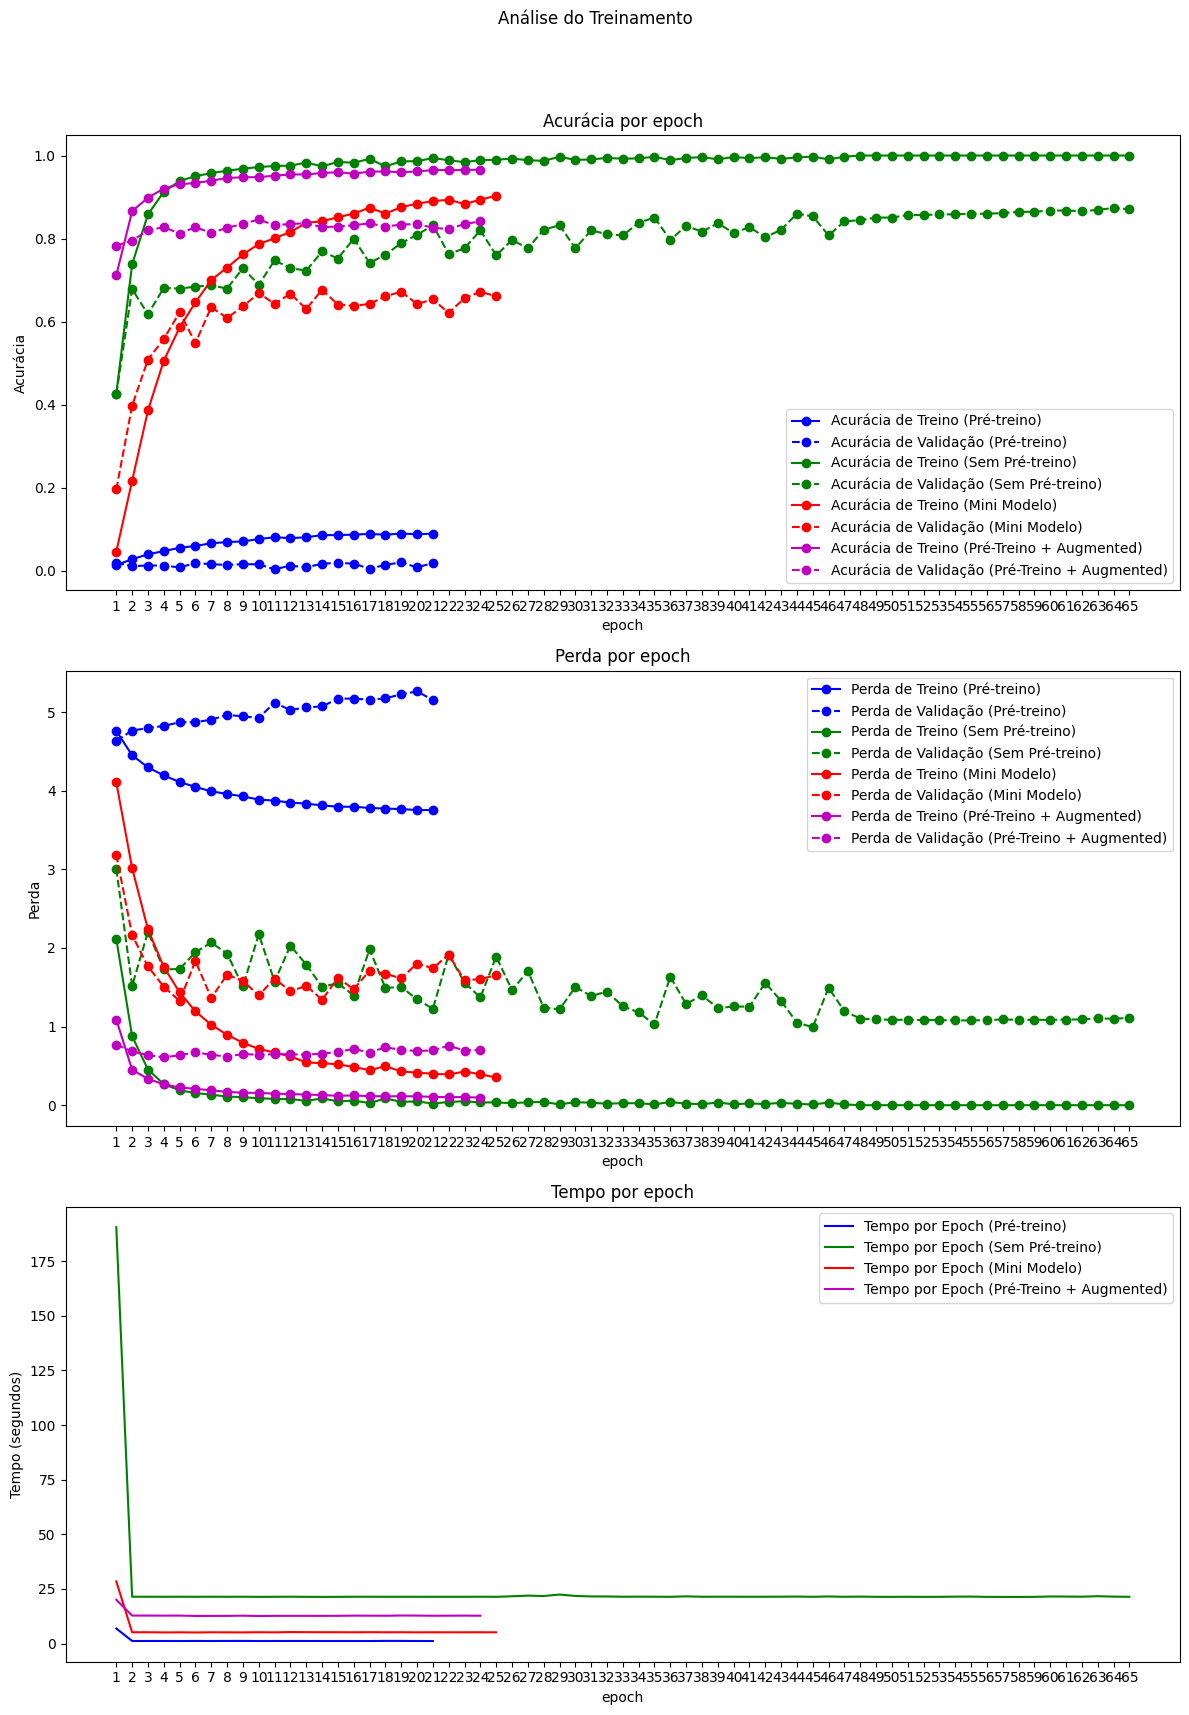

In [24]:
# Criar a figura e os eixos para os plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Análise do Treinamento')

# Plot 1: Acurácia de Treino e Validação
ax1.plot(epochs_range_com_pretreino, acc_com_pretreino, 'o-', label='Acurácia de Treino (Pré-treino)', color = 'b')
ax1.plot(epochs_range_com_pretreino, val_acc_com_pretreino, 'o--', label='Acurácia de Validação (Pré-treino)', color = 'b')
ax1.plot(epochs_range_sem_pretreino, acc_sem_pretreino, 'o-', label='Acurácia de Treino (Sem Pré-treino)', color = 'g')
ax1.plot(epochs_range_sem_pretreino, val_acc_sem_pretreino, 'o--', label='Acurácia de Validação (Sem Pré-treino)', color = 'g')
ax1.plot(epochs_range_mini_modelo, acc_mini_modelo, 'o-', label='Acurácia de Treino (Mini Modelo)', color = 'r')
ax1.plot(epochs_range_mini_modelo, val_acc_mini_modelo, 'o--', label='Acurácia de Validação (Mini Modelo)', color = 'r') # Corrected variable name
ax1.plot(epochs_range_com_pretreino_augmented, acc_com_pretreino_augmented, 'o-', label='Acurácia de Treino (Pré-Treino + Augmented)', color = 'm')
ax1.plot(epochs_range_com_pretreino_augmented, val_acc_com_pretreino_augmented, 'o--', label='Acurácia de Validação (Pré-Treino + Augmented)', color = 'm')


ax1.set_title('Acurácia por epoch')
ax1.set_xlabel('epoch')
ax1.set_ylabel('Acurácia')
ax1.legend(loc='lower right') # Para não atrapalhar o gráfico
ax1.set_xticks(range(1, epochs_range + 1))


# Plot 2: Perda de Treino e Validação
ax2.plot(epochs_range_com_pretreino, loss_com_pretreino, 'o-', label='Perda de Treino (Pré-treino)', color = 'b')
ax2.plot(epochs_range_com_pretreino, val_loss_com_pretreino, 'o--', label='Perda de Validação (Pré-treino)', color = 'b')
ax2.plot(epochs_range_sem_pretreino, loss_sem_pretreino, 'o-', label='Perda de Treino (Sem Pré-treino)', color = 'g')
ax2.plot(epochs_range_sem_pretreino, val_loss_sem_pretreino, 'o--', label='Perda de Validação (Sem Pré-treino)', color = 'g')
ax2.plot(epochs_range_mini_modelo, loss_mini_modelo, 'o-', label='Perda de Treino (Mini Modelo)', color = 'r')
ax2.plot(epochs_range_mini_modelo, val_loss_mini_modelo, 'o--', label='Perda de Validação (Mini Modelo)', color = 'r') # Corrected variable name
ax2.plot(epochs_range_com_pretreino_augmented, loss_com_pretreino_augmented, 'o-', label='Perda de Treino (Pré-Treino + Augmented)', color = 'm')
ax2.plot(epochs_range_com_pretreino_augmented, val_loss_com_pretreino_augmented, 'o--', label='Perda de Validação (Pré-Treino + Augmented)', color = 'm')


ax2.set_title('Perda por epoch')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Perda')
ax2.legend(loc='upper right')
ax2.set_xticks(range(1, epochs_range + 1))


# Plot 3: Tempo por Epoch
ax3.plot(epochs_range_com_pretreino, epoch_times_com_pretreino, label='Tempo por Epoch (Pré-treino)', color = 'b')
ax3.plot(epochs_range_sem_pretreino, epoch_times_sem_pretreino, label='Tempo por Epoch (Sem Pré-treino)', color = 'g')
ax3.plot(epochs_range_mini_modelo, epoch_times_mini_modelo, label='Tempo por Epoch (Mini Modelo)', color = 'r')
ax3.plot(epochs_range_com_pretreino_augmented, epoch_times_com_pretreino_augmented, label='Tempo por Epoch (Pré-Treino + Augmented)', color = 'm')

ax3.set_title('Tempo por epoch')
ax3.set_xlabel('epoch')
ax3.set_ylabel('Tempo (segundos)')
ax3.legend()
ax3.set_xticks(range(1, epochs_range + 1))


# Ajustar o layout para evitar sobreposição de títulos e rótulos
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Ajusta o layout, deixando espaço para o suptitle

# Mostrar o plot
plt.show()

In [25]:
print("Test dataset evaluation")
model_mini.evaluate(test_ds)
model_sem_pretreino.evaluate(test_ds) # -> Loss, accuracy
model_com_pretreino.evaluate(test_features, test_labels)
model_com_pretreino_augmented.evaluate(test_ds)

Test dataset evaluation
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6105 - loss: 1.4416
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8414 - loss: 1.1755
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0153 - loss: 4.6399
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8294 - loss: 0.6553


[0.6170669198036194, 0.8333333134651184]